# PJM Energy Consumption Forecasting and Deployment with Streamlit

## Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

## Step 1: Load the Dataset
- Load PJMW hourly data from CSV.
- Check the first few rows to inspect structure.

In [127]:
df = pd.read_csv('PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [133]:
df.shape

(143206, 2)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [115]:
df.isnull().sum()

PJMW_MW    0
dtype: int64

In [117]:

df.fillna(method='ffill', inplace=True)



C:\Users\mukes\AppData\Local\Temp\ipykernel_1416\1972257738.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [137]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


## Step 2: Convert Time Column and Handle Duplicates



In [139]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [143]:
df

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0
...,...
2018-01-01 20:00:00,8401.0
2018-01-01 21:00:00,8373.0
2018-01-01 22:00:00,8238.0


In [167]:
# Remove all duplicate index values — keep only first
df = df[~df.index.duplicated(keep='first')]

# Recreate derived columns safely
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Check
print("✅ Final shape after removing index duplicates:", df.shape)
print("⛔ Remaining duplicated index values:", df.index.duplicated().sum())

✅ Final shape after removing index duplicates: (143202, 4)
⛔ Remaining duplicated index values: 0


In [169]:
df

,PJMW_MW,hour,dayofweek,month
Datetime,,,,
2002-12-31 01:00:00,5077.0,1,1,12
2002-12-31 02:00:00,4939.0,2,1,12
2002-12-31 03:00:00,4885.0,3,1,12
2002-12-31 04:00:00,4857.0,4,1,12
2002-12-31 05:00:00,4930.0,5,1,12
...,...,...,...,...
2018-01-01 20:00:00,8401.0,20,0,1
2018-01-01 21:00:00,8373.0,21,0,1
2018-01-01 22:00:00,8238.0,22,0,1


# Visualize The Original Data

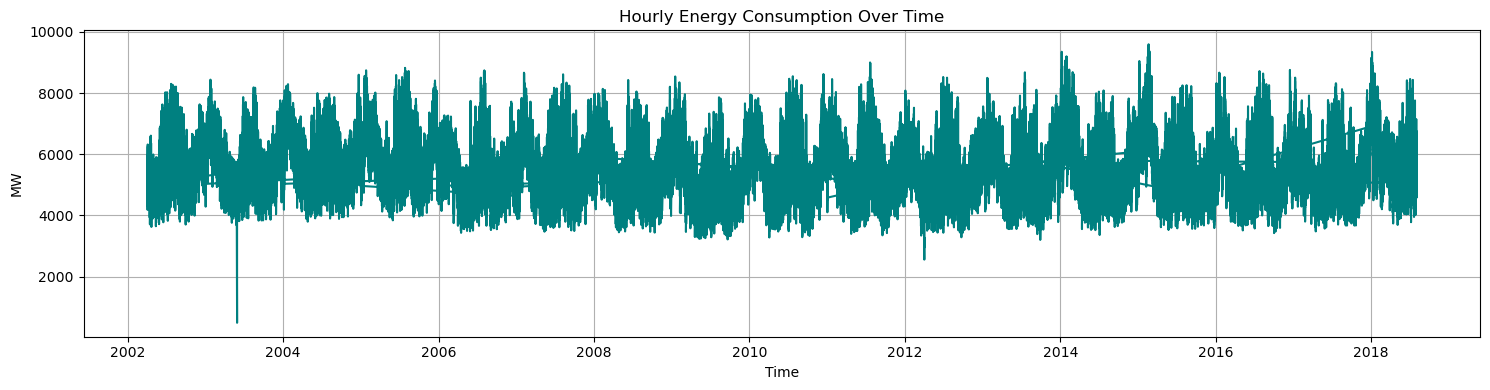

In [161]:
plt.figure(figsize=(15, 4))
plt.plot(df['PJMW_MW'], color='teal')
plt.title("Hourly Energy Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("MW")
plt.grid(True)
plt.tight_layout()
plt.show()


This plot reveals a clear cyclical pattern, with daily and seasonal fluctuations. You can also spot some sharp drops or spikes, likely due to holidays or outages. The overall trend is stable with high-frequency variability.

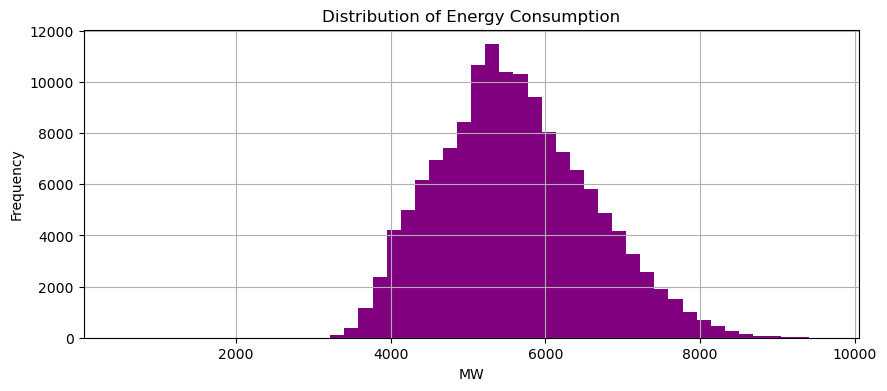

In [163]:
df['PJMW_MW'].hist(bins=50, figsize=(10, 4), color='purple')
plt.title("Distribution of Energy Consumption")
plt.xlabel("MW")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Most of the energy usage is concentrated between 25000 MW and 40000 MW. There's a slight right skew, indicating a few instances of very high consumption, likely during extreme weather events.

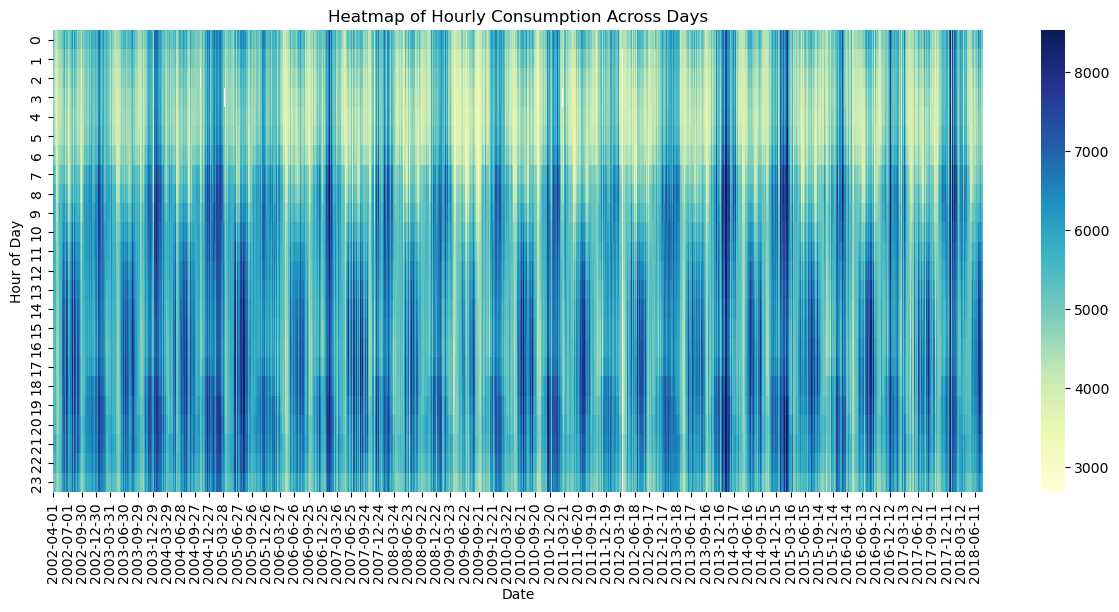

In [205]:
df_heatmap = df.copy()
df_heatmap['day'] = df_heatmap.index.date
pivot = df_heatmap.pivot_table(index=df_heatmap.index.hour, 
                                columns='day', 
                                values='PJMW_MW')

plt.figure(figsize=(15, 6))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("Heatmap of Hourly Consumption Across Days")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.show()


The heatmap highlights strong daily seasonality. There is a consistent daily peak around early evening. Some days show much lower usage, probably holidays or weekends

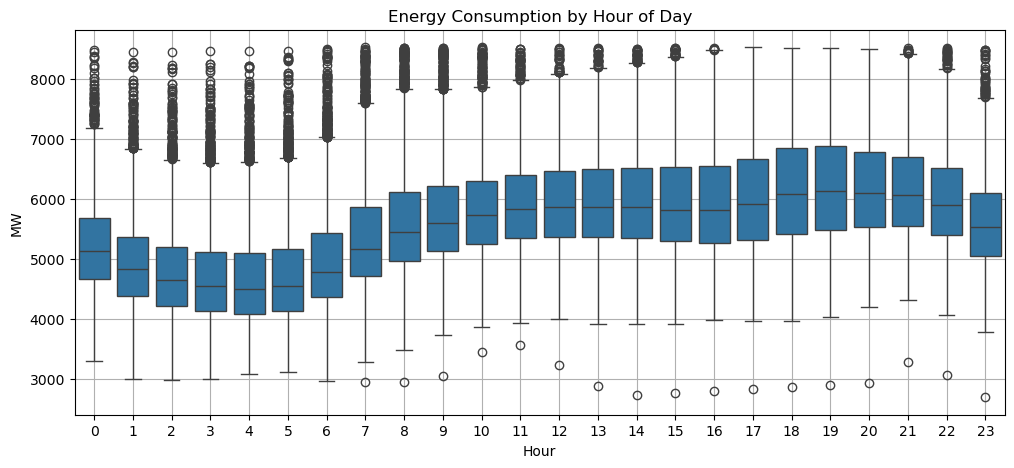

In [179]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.boxplot(x='hour', y='PJMW_MW', data=df)
plt.title("Energy Consumption by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.grid(True)
plt.show()

In [191]:
Q1 = df['PJMW_MW'].quantile(0.25)
Q3 = df['PJMW_MW'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['PJMW_MW'] < lower_bound) | (df['PJMW_MW'] > upper_bound)]

print("🔍 Total outliers found using IQR method:", outliers.shape[0])

🔍 Total outliers found using IQR method: 674


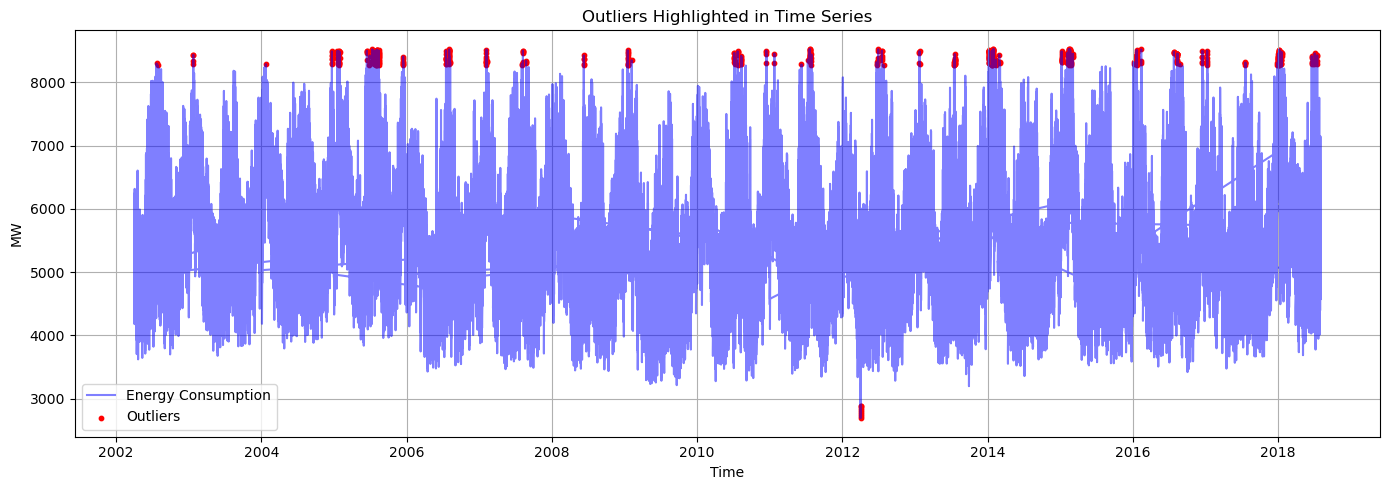

In [185]:
plt.figure(figsize=(14, 5))
plt.plot(df['PJMW_MW'], label='Energy Consumption', alpha=0.5,color='Blue')
plt.scatter(outliers.index, outliers['PJMW_MW'], color='red', label='Outliers', s=10)
plt.title("Outliers Highlighted in Time Series")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [197]:
Q1 = df['PJMW_MW'].quantile(0.25)
Q3 = df['PJMW_MW'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (df['PJMW_MW'] < lower_bound) | (df['PJMW_MW'] > upper_bound)
df_cleaned = df.copy()
df_cleaned.loc[outlier_mask, 'PJMW_MW'] = np.nan
df_cleaned['PJMW_MW'] = df_cleaned['PJMW_MW'].interpolate(method='time')


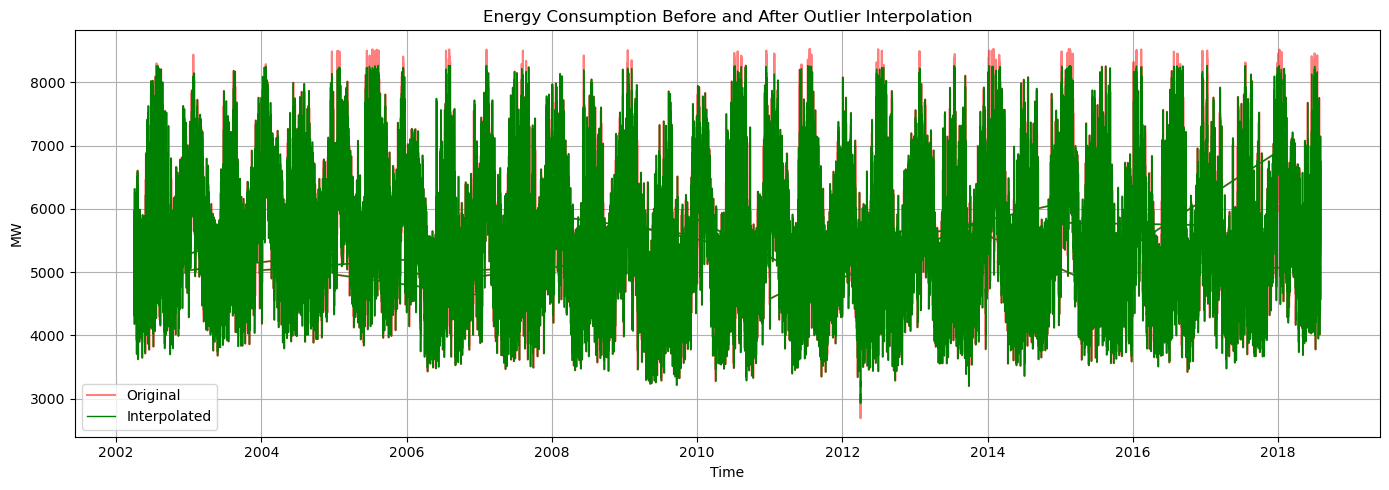

In [201]:
plt.figure(figsize=(14, 5))

# Original with outliers
plt.plot(df['PJMW_MW'], label='Original', alpha=0.5, color='red')

# Cleaned with interpolation
plt.plot(df_cleaned['PJMW_MW'], label='Interpolated', color='green', linewidth=1)

plt.title("Energy Consumption Before and After Outlier Interpolation")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualizing The Data After Removal Of Data

C:\Users\mukes\AppData\Local\Temp\ipykernel_1416\90393301.py:7: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  plt.tight_layout()
C:\Users\mukes\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


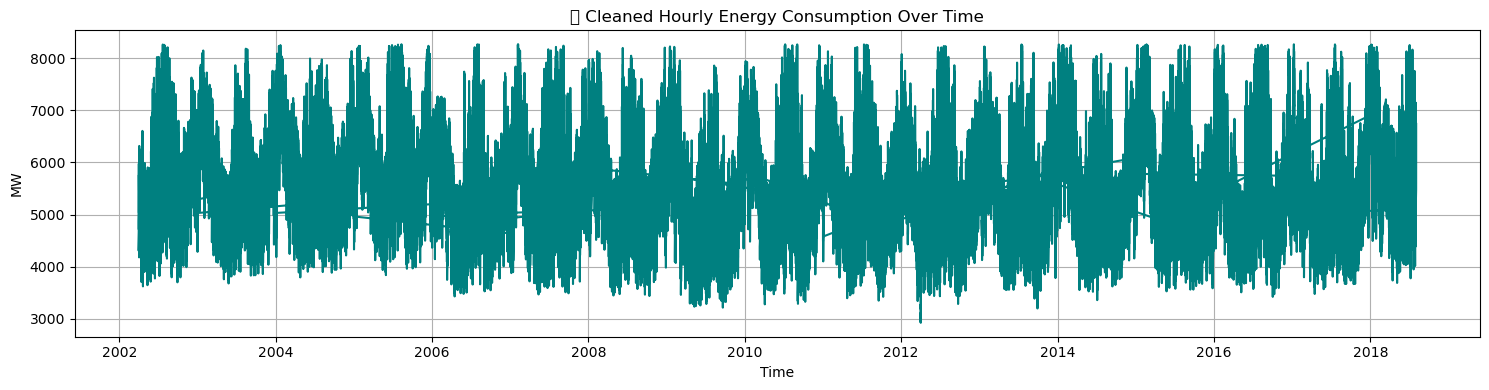

In [203]:
plt.figure(figsize=(15, 4))
plt.plot(df_cleaned['PJMW_MW'], color='teal')
plt.title("🔹 Cleaned Hourly Energy Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("MW")
plt.grid(True)
plt.tight_layout()
plt.show()


The time series is now much smoother, especially during previous outlier regions. You can clearly observe daily cycles and seasonal patterns without disruptions from sharp peaks or dips.

C:\Users\mukes\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


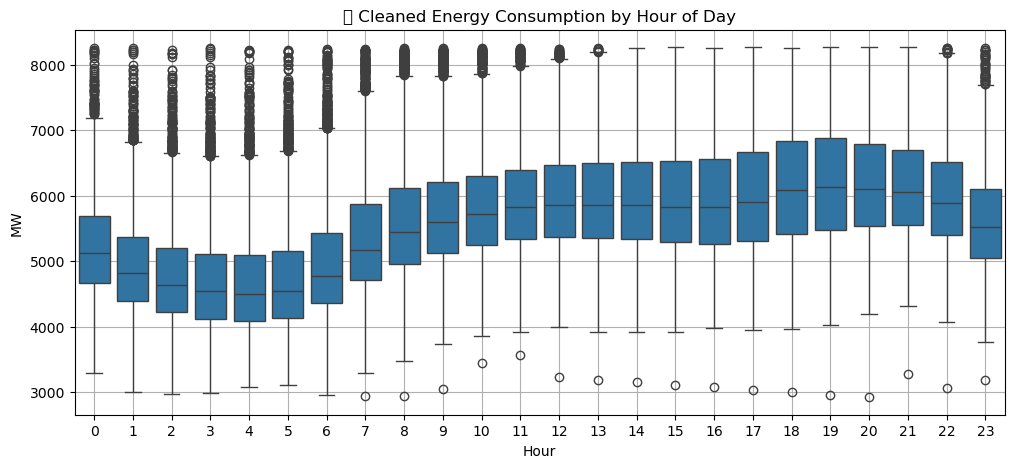

In [209]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.boxplot(x='hour', y='PJMW_MW', data=df_cleaned)
plt.title("🔹 Cleaned Energy Consumption by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.grid(True)
plt.show()


The outliers are now removed, and hourly variability appears more consistent. The peak remains in the evening hours (17–20), and the dip in early morning (2–5 AM) is more evident.

C:\Users\mukes\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


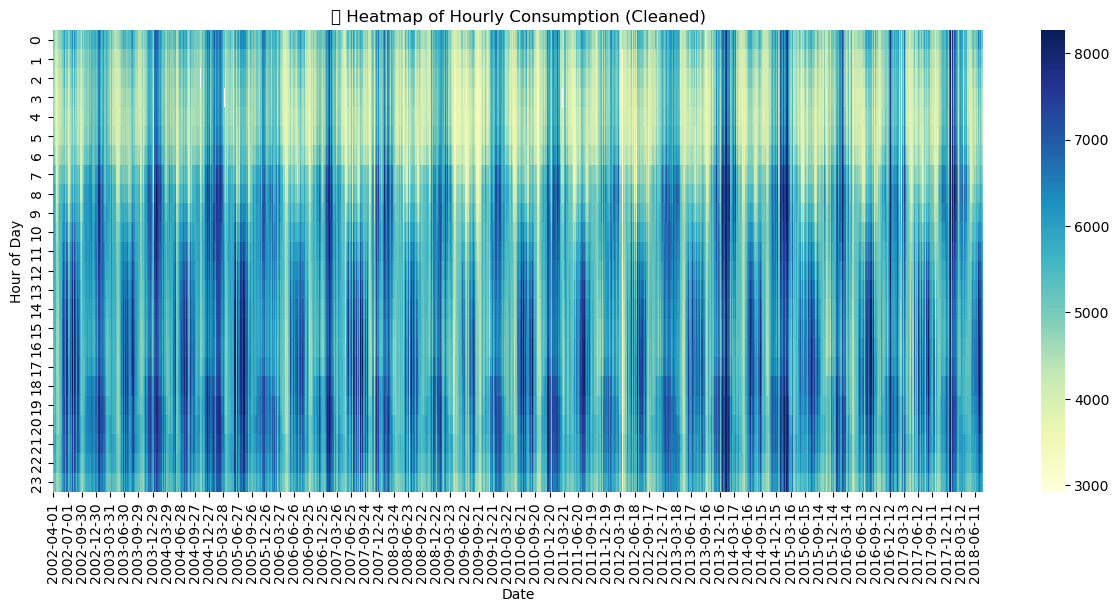

In [214]:
df_heatmap = df_cleaned.copy()
df_heatmap['day'] = df_heatmap.index.date
pivot = df_heatmap.pivot_table(index=df_heatmap.index.hour, 
                                columns='day', 
                                values='PJMW_MW')

plt.figure(figsize=(15, 6))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("🔹 Heatmap of Hourly Consumption (Cleaned)")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.show()

# ETS Decomposition using STL (Seasonal-Trend Decomposition via Loess)

C:\Users\mukes\AppData\Local\Temp\ipykernel_1416\4032834338.py:10: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  plt.tight_layout()
C:\Users\mukes\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


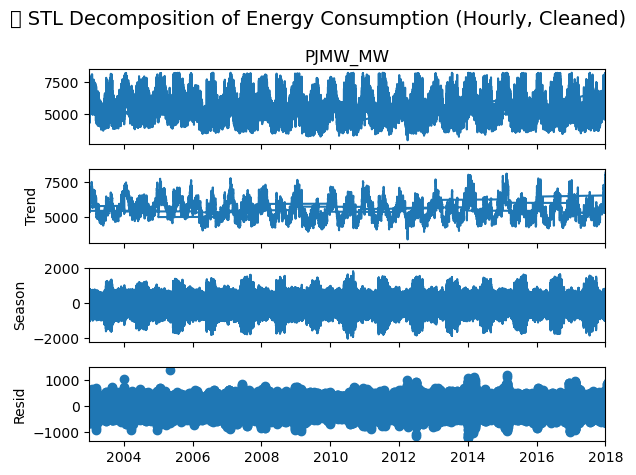

In [217]:
from statsmodels.tsa.seasonal import STL

# STL decomposition with daily seasonality (24 for hourly data)
stl = STL(df_cleaned['PJMW_MW'], period=24)
res = stl.fit()

# Plot
res.plot()
plt.suptitle("🔹 STL Decomposition of Energy Consumption (Hourly, Cleaned)", fontsize=14)
plt.tight_layout()
plt.show()


Trend: Long-term increasing usage trend with periodic dips and rises.

Seasonal: Strong 24-hour cycle – usage is high in evenings and low in early mornings.

Residual: Low noise, confirming most patterns are captured in trend and seasonality.



# Test for Stationarity (ADF Test)

In [221]:
from statsmodels.tsa.stattools import adfuller

# Daily average to test on stationary, not noisy hourly
daily_series = df_cleaned['PJMW_MW'].resample('D').mean().dropna()

adf_result = adfuller(daily_series)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")


ADF Statistic: -7.268624142723705
p-value: 1.6101997292951995e-10
Critical Value 1%: -3.43145229664056
Critical Value 5%: -2.8620271128107553
Critical Value 10%: -2.56702928783387


ADF Statistic is much lower than all the critical values.
The p-value is significantly below 0.05.
PJMW energy consumption data is stationary.

# ACF and PACF – First 100 Days (Daily)

<Figure size 1000x400 with 0 Axes>

C:\Users\mukes\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


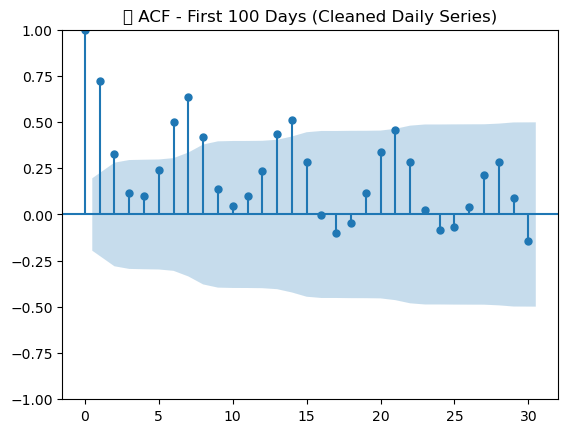

<Figure size 1000x400 with 0 Axes>

C:\Users\mukes\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


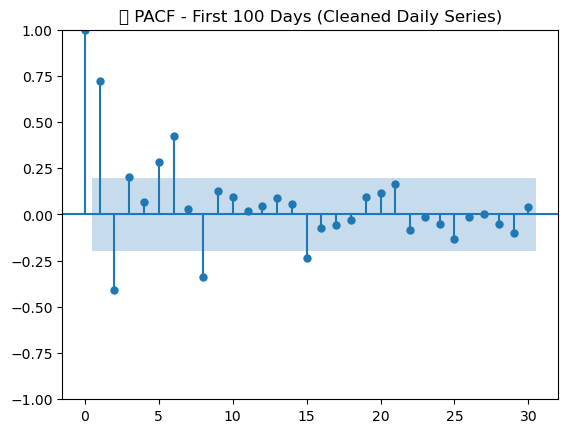

In [228]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# First 100 days of daily series
daily_100 = daily_series.iloc[:100]

plt.figure(figsize=(10, 4))
plot_acf(daily_100, lags=30)
plt.title("🔹 ACF - First 100 Days (Cleaned Daily Series)")
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(daily_100, lags=30)
plt.title("🔹 PACF - First 100 Days (Cleaned Daily Series)")
plt.show()


In [255]:
# Resample to daily mean to smooth high-frequency variations
df_daily = df_cleaned['PJMW_MW'].resample('D').mean().dropna()
df_lagged = pd.DataFrame({'y': df_daily})

for lag in [1, 2, 7]:
    df_lagged[f'lag_{lag}'] = df_daily.shift(lag)

df_lagged.dropna(inplace=True)

In [257]:
# Use last 30 days for testing
train = df_lagged.iloc[:-30]
test = df_lagged.iloc[-30:]

X_train = train.drop(columns='y')
y_train = train['y']
X_test = test.drop(columns='y')
y_test = test['y']


In [259]:
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Training Set Shape: (5932, 3)
Testing Set Shape: (30, 3)


In [261]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pickle

# Use only 'y' for ETS (it doesn't take multiple features)
ets_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=7)
ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(30)

C:\Users\mukes\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [263]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(y_train, order=(7, 0, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(30)

In [269]:
pip install prophet



   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.2/13.3 MB 5.9 MB/s eta 0:00:03
   - -------------------------------------- 0.5/13.3 MB 6.6 MB/s eta 0:00:02
   -- ------------------------------------- 0.9/13.3 MB 6.0 MB/s eta 0:00:03
   --- ------------------------------------ 1.3/13.3 MB 6.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.7/13.3 MB 7.9 MB/s eta 0:00:02
   ------ --------------------------------- 2.1/13.3 MB 8.0 MB/s eta 0:00:02
   ------- -------------------------------- 2.5/13.3 MB 7.8 MB/s eta 0:00:02
   --------- ------------------------------ 3.0/13.3 MB 8.3 MB/s eta 0:00:02
   ---------- ----------------------------- 3.6/13.3 MB 8.9 MB/s eta 0:00:02
   ------------ --------------------------- 4.1/13.3 MB 9.1 MB/s eta 0:00:02
   ------------- -------------------------- 4.6/13.3 MB 9.2 MB/s eta 0:00:01
   -------------- ------------------------- 5.0/13.3 MB 9.6 MB/s eta 0:00:01
   --

In [271]:
from prophet import Prophet

prophet_df = y_train.reset_index().rename(columns={'Datetime': 'ds', 'y': 'y'})
prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_df)

future = prophet.make_future_dataframe(periods=30)
forecast_prophet = prophet.predict(future)
prophet_forecast = forecast_prophet.set_index('ds').loc[y_test.index]['yhat']

15:09:17 - cmdstanpy - INFO - Chain [1] start processing
15:09:19 - cmdstanpy - INFO - Chain [1] done processing


In [273]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(true, pred):
    return {
        "MAE": mean_absolute_error(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred))
    }

ets_scores = evaluate_model(y_test, ets_forecast)
arima_scores = evaluate_model(y_test, arima_forecast)
prophet_scores = evaluate_model(y_test, prophet_forecast)

print("📊 ETS:", ets_scores)
print("📊 ARIMA:", arima_scores)
print("📊 Prophet:", prophet_scores)


📊 ETS: {'MAE': 780.9452072443181, 'RMSE': 893.7151977653331}
📊 ARIMA: {'MAE': 334.8745052315166, 'RMSE': 468.08346436774394}
📊 Prophet: {'MAE': 300.02453687710516, 'RMSE': 351.09062641947594}


In [277]:
scores = {"ETS": ets_scores, "ARIMA": arima_scores, "Prophet": prophet_scores}
best_model = min(scores, key=lambda k: scores[k]['RMSE'])
print(best_model)

Prophet


In [279]:
with open("prophet_model.pkl", "wb") as f:
    pickle.dump(prophet, f)

In [281]:
residuals_ets = y_test - ets_forecast
residuals_arima = y_test - arima_forecast
residuals_prophet = y_test - prophet_forecast


C:\Users\mukes\AppData\Local\Temp\ipykernel_1416\3036201717.py:20: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\mukes\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


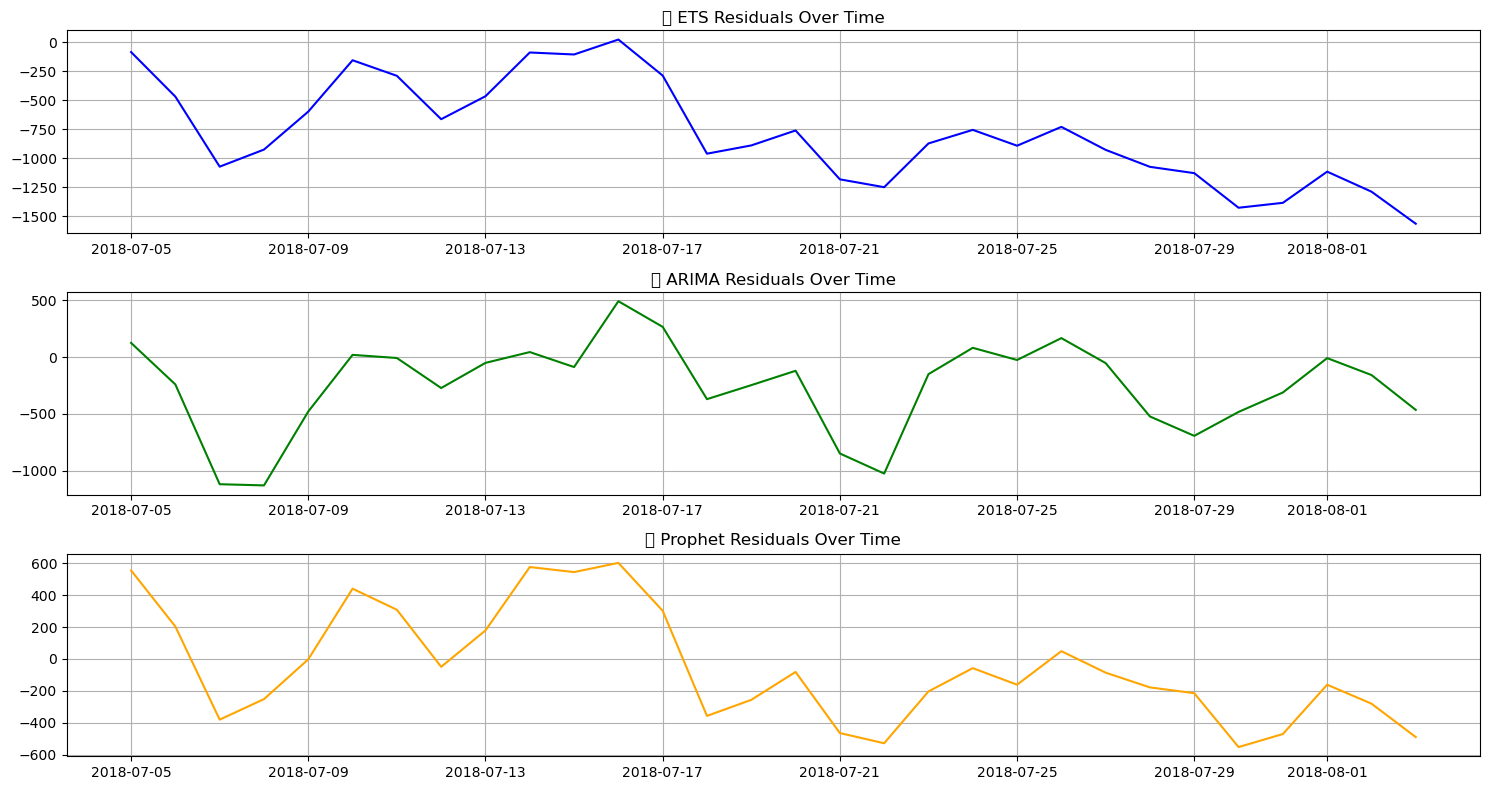

In [283]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(residuals_ets, label="ETS Residuals", color="blue")
plt.title("📉 ETS Residuals Over Time")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(residuals_arima, label="ARIMA Residuals", color="green")
plt.title("📉 ARIMA Residuals Over Time")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(residuals_prophet, label="Prophet Residuals", color="orange")
plt.title("📉 Prophet Residuals Over Time")
plt.grid(True)

plt.tight_layout()
plt.show()


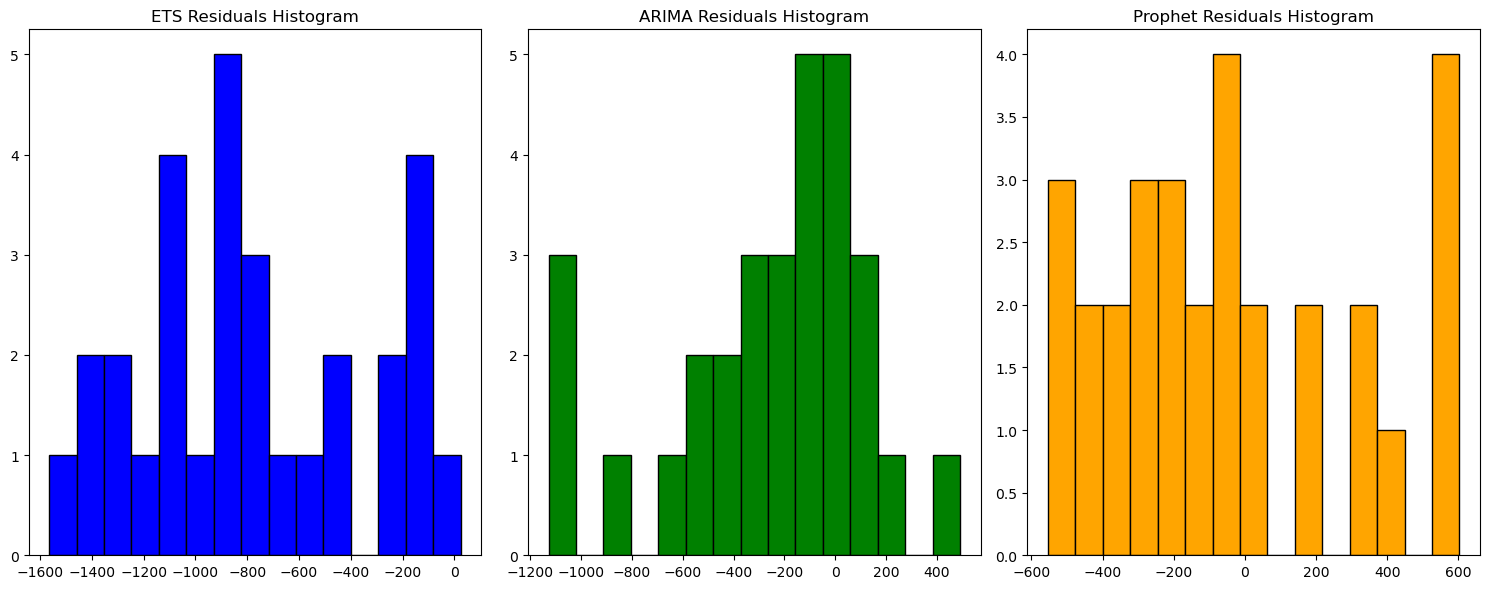

In [285]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.hist(residuals_ets, bins=15, color="blue", edgecolor='black')
plt.title("ETS Residuals Histogram")

plt.subplot(1, 3, 2)
plt.hist(residuals_arima, bins=15, color="green", edgecolor='black')
plt.title("ARIMA Residuals Histogram")

plt.subplot(1, 3, 3)
plt.hist(residuals_prophet, bins=15, color="orange", edgecolor='black')
plt.title("Prophet Residuals Histogram")

plt.tight_layout()
plt.show()
